In [1]:
from tensorflow import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from time import time
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
def append_ext(fn):
    return fn+".jpg"

#loading dataset 
df = pd.read_csv("dataset.csv")

df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)

columns = ['gummy','golden_proportion ','gap','crowding','incisal embrassure ','color','Central line','Crooked','Central Incisor W/H Ratio','Black triangle','perfect']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   img                        194 non-null    object 
 1   gummy                      194 non-null    int64  
 2   golden_proportion          194 non-null    float64
 3   gap                        194 non-null    int64  
 4   crowding                   194 non-null    float64
 5   incisal embrassure         194 non-null    float64
 6   color                      194 non-null    float64
 7   Central line               194 non-null    float64
 8   gum tissue health          194 non-null    float64
 9   Crooked                    194 non-null    float64
 10  Central Incisor W/H Ratio  194 non-null    float64
 11  Black triangle             194 non-null    int64  
 12  perfect                    194 non-null    int64  
 13  labels                     194 non-null    object 

In [3]:
#shuffle dataframe before splitting 
df=df.sample(frac=1).reset_index(drop=True)

In [4]:
# # preprocessing the training set
# train_data_generation = ImageDataGenerator(rescale=1./255)

# training_set = train_data_generation.flow_from_dataframe(dataframe=traindf,
#                                                          directory="./cropped_teeth",
#                                                          x_col="img",
#                                                          y_col=columns,
#                                                          target_size=(224, 224),
#                                                          batch_size=1,
#                                                          class_mode="raw",seed=0)
# # preprocessing the testing set
# valid_data_generation = ImageDataGenerator(rescale=1./255)

# valid_set = valid_data_generation.flow_from_dataframe(dataframe=validdf,
#                                                          directory="./cropped_teeth",
#                                                          x_col="img",
#                                                          y_col=columns,
#                                                          target_size=(224, 224),
#                                                          batch_size=1,
#                                                          class_mode="raw",seed=0)

# # preprocessing the testing set
# test_data_generation = ImageDataGenerator(rescale=1./255)

# test_set = test_data_generation.flow_from_dataframe(dataframe=testdf,
#                                                          directory="./cropped_teeth",
#                                                          x_col="img",
#                                                          y_col=None,
#                                                          target_size=(224, 224),
#                                                          batch_size=1,
#                                                          class_mode=None,seed=0)

In [22]:
# preprocessing the training set
train_data_generation = ImageDataGenerator(rescale=1./255)

training_set = train_data_generation.flow_from_dataframe(dataframe=df[:155],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=columns,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode="raw")
# preprocessing the testing set
valid_data_generation = ImageDataGenerator(rescale=1./255)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[155:175],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=columns,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode="raw")

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[175:],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=None,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode=None)


Found 155 validated image filenames.
Found 20 validated image filenames.
Found 19 validated image filenames.


In [23]:
def mobilenet(input_shape):
  
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for i in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(11, activation='softmax')(x)
  
  model = Model(input, output)
  return model


In [24]:
model= mobilenet([224,224,3])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_54 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d_26 (Depthwi (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_55 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 112, 112, 32)      0   

In [25]:
# vgg
es=keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    mode="auto",
    restore_best_weights=True,
)

model.compile(optimizer='adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])
history=model.fit(x=training_set, validation_data=valid_set, epochs=20,callbacks=[es])

Epoch 1/20
5/5 [==============================] - 49s 11s/step - loss: 0.6027 - accuracy: 0.0323 - val_loss: 0.6815 - val_accuracy: 0.3500
Epoch 2/20
5/5 [==============================] - 15s 3s/step - loss: 0.4263 - accuracy: 0.2065 - val_loss: 0.6705 - val_accuracy: 0.3500
Epoch 3/20
5/5 [==============================] - 16s 3s/step - loss: 0.3911 - accuracy: 0.1871 - val_loss: 0.6620 - val_accuracy: 0.0500
Epoch 4/20
5/5 [==============================] - 16s 3s/step - loss: 0.3726 - accuracy: 0.2000 - val_loss: 0.6539 - val_accuracy: 0.0500


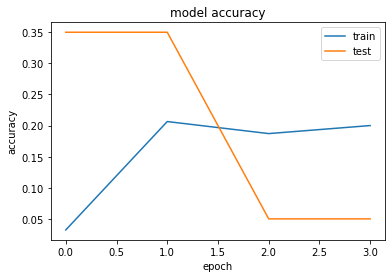

In [27]:
history.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [28]:
predictions= model.predict(test_set)
y=[]
print("10 Sample predictions:")
for pred in predictions:

  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred)
  

10 Sample predictions:
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:

# test=pd.DataFrame(model.predict(test_set))
# test.columns=columns
# for i in range(6):
#     img, label = test_set.next()
#     print(test.iloc[[i]])   
#     plt.imshow(img[0])
#     plt.show()

test=(model.predict(test_set))
for pred in test:
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
      
test=pd.DataFrame(test) 
test.columns=columns
test

,gummy,golden_proportion,gap,crowding,incisal embrassure,color,Central line,Crooked,Central Incisor W/H Ratio,Black triangle,perfect
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
